In [127]:
import os
from PIL import Image
import glob

import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras import metrics

In [2]:
def load_unlabeled_dataset():
    images = []
    # Labeled data
    for f in glob.iglob("./dataset/train/*/*"):
        images.append(np.asarray(Image.open(f)))
    
    # Unlabeled data
    for f in glob.iglob("./dataset/unlabeled/*"):
        images.append(np.asarray(Image.open(f)))
        
    images = np.array(images)
    return images

In [3]:
# Load unlabeled and labeled train data
unlabeled_data = load_unlabeled_dataset()

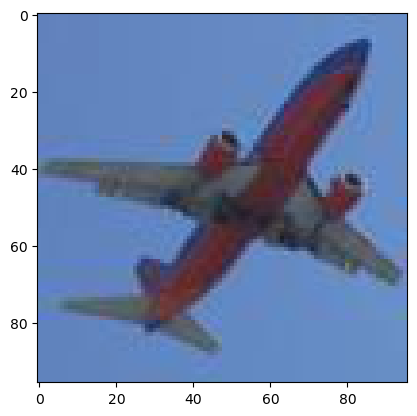

In [4]:
# View an example of an image
plt.imshow(unlabeled_data[0])

In [5]:
def normalize_and_greyscale(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_normalized = cv.normalize(gray, None, 0, 1.0, cv.NORM_MINMAX, dtype=cv.CV_32F)
    img_normalized = np.reshape(img_normalized, (96, 96, 1))
    return img_normalized

In [6]:
# Normalize the images
unlabeled_data = [normalize_and_greyscale(img) for img in unlabeled_data]
unlabeled_data = np.asarray(unlabeled_data)

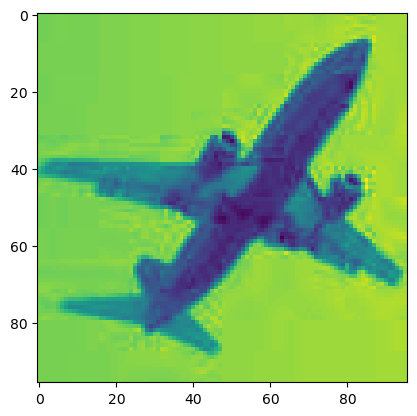

In [7]:
plt.imshow(unlabeled_data[0])

In [9]:
# Split into train and test sets
x_train, x_test, _, _ = train_test_split(unlabeled_data, unlabeled_data, test_size=0.1)

In [133]:
def build_autoencoder_0():
    model = Sequential()
    model.add(layers.Input(shape=(96, 96, 1)))

    # Encoder
    model.add(layers.Conv2D(16, (3, 3), activation="relu", padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), padding="same"))
    model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), padding="same"))
    model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), padding="same"))
    model.add(layers.Conv2D(128, (3, 3), activation="relu", padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), padding="same"))
    
    # Decoder
    model.add(layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same"))
    model.add(layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same"))
    model.add(layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same"))
    model.add(layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same"))
    model.add(layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same"))
    
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[metrics.RootMeanSquaredError()])
    
    return model
    

In [145]:
def build_autoencoder():
    model = Sequential()
    model.add(layers.Input(shape=(96, 96, 1)))
    
    # Encoder
    model.add(layers.Conv2D(32, (5, 5), (2, 2), activation="tanh", padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(48, (5, 5), (2, 2), activation="tanh", padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (5, 5), (2, 2), activation="tanh", padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(8, (5, 5), (2, 2), activation="tanh", padding="same"))
    model.add(layers.BatchNormalization())
    
    # Decoder
    model.add(layers.Conv2DTranspose(8, (5, 5), (2, 2), activation="tanh", padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(32, (5, 5), (2, 2), activation="tanh", padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(48, (5, 5), (2, 2), activation="tanh", padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(64, (5, 5), (2, 2), activation="tanh", padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(1, (5, 5), activation="sigmoid", padding="same"))
    
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[metrics.RootMeanSquaredError()])
    
    return model

In [146]:
# Build autoencoder model
model = build_autoencoder()
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 48, 48, 32)        832       
_________________________________________________________________
batch_normalization_28 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 24, 24, 48)        38448     
_________________________________________________________________
batch_normalization_29 (Batc (None, 24, 24, 48)        192       
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 12, 12, 64)        76864     
_________________________________________________________________
batch_normalization_30 (Batc (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 6, 6, 8)         

In [147]:
class DataGenerator(Sequence):
    def __init__(self, x_set, batch_size=64):
        self.x = x_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.floor(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_x

In [ ]:
train_gen = DataGenerator(x_train)
test_gen = DataGenerator(x_test)
model.fit(train_gen, epochs=50, validation_data=test_gen)

Epoch 1/50
1546/1546 [==============================] - 117s 73ms/step - loss: 0.5496 - root_mean_squared_error: 0.1152 - val_loss: 0.5526 - val_root_mean_squared_error: 0.1194
Epoch 2/50
1546/1546 [==============================] - 114s 74ms/step - loss: 0.5392 - root_mean_squared_error: 0.0974 - val_loss: 0.5470 - val_root_mean_squared_error: 0.1110
Epoch 3/50
1546/1546 [==============================] - 114s 74ms/step - loss: 0.5372 - root_mean_squared_error: 0.0935 - val_loss: 0.5361 - val_root_mean_squared_error: 0.0912
Epoch 4/50
1546/1546 [==============================] - 118s 76ms/step - loss: 0.5360 - root_mean_squared_error: 0.0912 - val_loss: 0.5399 - val_root_mean_squared_error: 0.0982
Epoch 5/50
1546/1546 [==============================] - 119s 77ms/step - loss: 0.5353 - root_mean_squared_error: 0.0898 - val_loss: 0.5363 - val_root_mean_squared_error: 0.0920
Epoch 6/50
1546/1546 [==============================] - 114s 74ms/step - loss: 0.5348 - root_mean_squared_error: 0.

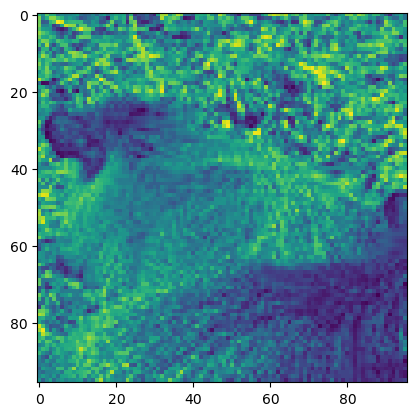

In [140]:
plt.imshow(x_test[15])

In [94]:
prediction = model.predict(x_test)

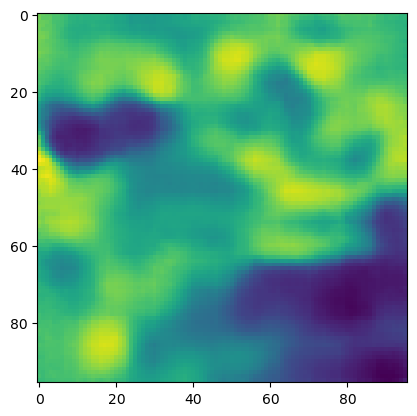

In [139]:
plt.imshow(prediction[15])